In [1]:
# Fast latent Walk Music videos by David Graham
# Using SDXL-turbo to generate music videos

# Untested in Colab, only run locally with jupyter notebook.
# The first inferrence is usually a little slow, speeds up with repeated use.

# Tricky latent interpolation code is adapted from 
# here: https://github.com/nateraw/stable-diffusion-videos/tree/main
# and here: https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355

# LoRA was inspired by "Shitty Doodle Drawings by EZG": https://civitai.com/models/253322
# SDXL LoRA was trained using this notebook: http://localhost:8888/notebooks/Downloads/AutoTrain_Dreambooth.ipynb
# Dataset was hand drawn by myself and my housemates: Abby Bonds, Lizzy Allison, Maizie Rayne Laughton and Teddy Clarke.
# Dataset and LoRA can be found here: https://huggingface.co/datasets/DGraham1/doodles

# Onset detection is adapted from this tutourial: https://www.freecodecamp.org/news/use-python-to-detect-music-onsets/

# Modified ChatGPT code is littered throughout this notebook, I've noted where. 
# ChatGPT 3.5, free version was used between the dates of 09/01/24 and 15/01/24

In [2]:
! pip install --quiet librosa
! pip install --quiet --upgrade diffusers transformers accelerate compel
! pip install --quiet imageio[ffmpeg] moviepy

from compel import Compel, ReturnedEmbeddingsType
from diffusers import AutoPipelineForText2Image, LCMScheduler 
import torch
from PIL import Image, ImageOps
from IPython.display import display, Video
import librosa
import os
import numpy as np
import glob
import base64
import pathlib
import mimetypes
import IPython.display
import os
import imageio
from moviepy.editor import VideoFileClip, AudioFileClip, VideoClip, clips_array

IMAGE_SIZE = 512
torch_device = "cuda:0"

In [3]:
# Set your paths
image_sequence_path = "homebrew_interpolation_tests"
audio_file_path = "C:/Users/David/Downloads/poppin_kick.wav"
output_video_path = 'C:/Users/David/Desktop/ML_coursework/DMLAP/python/video_tests/video.mp4'

In [4]:
#define some helper functions

#this function detects onsets in the audio file and returns a list of times in seconds
def get_audio_onsets(audio_file_path):
    x, sr = librosa.load(audio_file_path)
    onset_frames = librosa.onset.onset_detect(y=x, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
    onset_times = librosa.frames_to_time(onset_frames)
    return onset_times

#this function conditions our imput prompts to make them more stylistically consistent. 
#The custom trained LoRA is invoked with the keyword "DaveyDoodle"
#weights of the keywords are adjusted using compel's "+" and "-".
#adapted from code by chatGPT
def process_prompts(prompts):
    processed_prompts = []

    for prompt in prompts:

        # edit this to change style or invoke different LoRA
        details = ", black and white, sketch by DaveyDoodle+++++++++++." #really upping the weight of the custom LoRA - seems neccessary in my experiments
        
        processed_prompt = f"{prompt} {details}"
        processed_prompts.append(processed_prompt)

    return processed_prompts

#spherical interpolation function for interpolating between noisy latents
#from https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355 (also used in Nateraw's stable_diffusion_videos
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """ helper function to spherically interpolate two arrays v1 v2 """

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2
#function to generate video. Adapted from chatGPT.
def create_video(image_sequence_path, audio_file_path, output_video_path, fps):
    # Load the image sequence
    image_files = sorted([os.path.join(image_sequence_path, f) for f in os.listdir(image_sequence_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    images = [imageio.imread(img) for img in image_files]

    # Convert grayscale images to RGB format. (fix this, hacky: the video generation code can't handle 1 channel)
    images = [np.stack((img,) * 3, axis=-1) for img in images]

    # Create a video clip from the image sequence
    image_clip = VideoClip(lambda t: images[int(t * fps)], duration=len(images) / fps)

    # Load the audio clip
    audio_clip = AudioFileClip(audio_file_path)

    # Set the audio of the video clip
    video_clip = image_clip.set_audio(audio_clip)

    # Write the final video file
    video_clip.write_videofile(output_video_path, codec='libx264', audio_codec='aac', fps=fps)

In [5]:
# Here we detect onsets in the audio file and push the onset times to an array called beatmap_contents
# TODO: figure out extracting whole amplitude envelopes instead of offsets. Maybe using librosa.feature.rms()
# or a more sophisticated multiband method.

beatmap_contents = get_audio_onsets(audio_file_path)

print("times of onsets:")
print(beatmap_contents)

times of onsets:
[1.62539683e-01 7.19818594e-01 1.55573696e+00 4.38857143e+00
 4.94585034e+00 6.03718821e+00 6.59446712e+00 7.12852608e+00
 8.21986395e+00 9.31120181e+00 9.58984127e+00 1.03793197e+01
 1.09598186e+01 1.12152381e+01 1.14706576e+01 1.17725170e+01
 1.18886168e+01 1.25619955e+01 1.28638549e+01 1.31192744e+01
 1.47446712e+01 1.61378685e+01 1.69505669e+01 1.74846259e+01
 1.83205442e+01 1.84366440e+01 1.91100227e+01 2.02013605e+01
 2.06193197e+01 2.09676190e+01 2.34753741e+01 2.56580499e+01
 2.71673469e+01 2.78407256e+01 2.86766440e+01 3.00466213e+01
 3.22060771e+01 3.27633560e+01 3.43887528e+01 3.54800907e+01
 3.58980499e+01 3.63160091e+01 3.65714286e+01 3.71287075e+01
 3.76627664e+01 3.80807256e+01 3.84986848e+01 3.87541043e+01
 3.93113832e+01 3.98454422e+01 4.02634014e+01 4.03795011e+01
 4.06813605e+01 4.09367800e+01 4.14940590e+01 4.17726984e+01
 4.20281179e+01 4.24228571e+01 4.31194558e+01 4.33980952e+01
 4.36767347e+01 4.38160544e+01 4.39553741e+01 4.40946939e+01
 4.4210

In [6]:
#We're using SDXL-turbo, which only needs one inerence step. There's a lot of frames to generate so speed is important.
pipeline = AutoPipelineForText2Image.from_pretrained(
  "stabilityai/sdxl-turbo",
  variant="fp16",
  use_safetensors=True,
  torch_dtype=torch.float16
).to("cuda")

pipeline.load_lora_weights("DGraham1/auto_dreambooth_test")

compel = Compel(
  tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] ,
  text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
  returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
  requires_pooled=[False, True]
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
# Apparently using these can speed up sdxl-turbo a little more.
# Here for details: https://huggingface.co/docs/diffusers/main/en/using-diffusers/sdxl_turbo

# This one isn't supported on windows at time of writing though:
# pipeline.unet = torch.compile(pipeline.unet, mode="reduce-overhead", fullgraph=True)

In [8]:
# This one is.
pipeline.upcast_vae()

In [9]:
#define out prompts here: 
#adapted from code by chatGPT

# I'm using a huge list of prompts and seeds here for a full track, at 1 prompt per second

# it's best to do this manually to have more control. It will deviate from the style so experimenting with 
# different keyframe seeds is necessary for stylistic consistency. chatGPT is helpful to get a list started, 
# check chatGPT's list with the "inspect all prompts" cell,
# then tweak each prompt and seed "inspect an individual prompt" cell below. It will suggest alternitive seeds, too. 

# one word prompts seem to work better, though changing one word at a time also works.
combined_array = [
    {"prompt": "cow", "seed": 255}, #0
    {"prompt": "tree", "seed": 746}, #1
    {"prompt": "apple", "seed": 157}, #2
    {"prompt": "bird", "seed": 235}, #3

    # uncomment these to generate full video. (this will take an hour or so in the generation stage)
    # {"prompt": "bottle", "seed": 756}, #4
    # {"prompt": "penguin", "seed": 17}, #5
    # {"prompt": "baby", "seed": 985}, #6
    # {"prompt": "cup", "seed": 768}, #7
    # {"prompt": "trampoline", "seed": 954}, #8 
    # {"prompt": "mop", "seed": 0}, #9
    # {"prompt": "couch", "seed": 625}, #10
    # {"prompt": "skateboard", "seed": 243}, #11
    # {"prompt": "apple", "seed": 329}, #12
    # {"prompt": "tree", "seed": 829}, #13
    # {"prompt": "hedge", "seed": 445}, #14
    # {"prompt": "pitchfork", "seed": 71}, #15
    # {"prompt": "toad", "seed": 38}, #16
    # {"prompt": "house", "seed": 202}, #17
    # {"prompt": "book", "seed": 983}, #18
    # {"prompt": "Ocean", "seed": 883}, #19
    # {"prompt": "Mountain", "seed": 957}, #20
    # {"prompt": "Mountain", "seed": 989}, #21
    # {"prompt": "Sun", "seed": 35}, #22
    # {"prompt": "Moon", "seed": 220}, #23
    # {"prompt": "Star", "seed": 1554}, #24
    # {"prompt": "treehouse", "seed": 904}, #25
    # {"prompt": "fan", "seed": 985}, #26
    # {"prompt": "plant", "seed": 768}, #27
    # {"prompt": "mushroom", "seed": 954}, #28 
    # {"prompt": "mushroom", "seed": 0}, #29
    # {"prompt": "casette", "seed": 45}, #30
    # {"prompt": "banana", "seed": 243}, #31
    # {"prompt": "fungus", "seed": 798}, #32
    # {"prompt": "sheep", "seed": 829}, #33
    # {"prompt": "church", "seed": 1005}, #34
    # {"prompt": "bird", "seed": 71}, #35
    # {"prompt": "wine", "seed": 38}, #36
    # {"prompt": "sword", "seed": 879}, #37
    # {"prompt": "gameboy", "seed": 983}, #38
    # {"prompt": "castle", "seed": 8456}, #39
    # {"prompt": "fortress", "seed": 957}, #40
    # {"prompt": "kangaroo", "seed": 989}, #41
    # {"prompt": "goblin", "seed": 35}, #42
    # {"prompt": "pipe", "seed": 220}, #43
    # {"prompt": "tankard", "seed": 1554}, #44
    # {"prompt": "dragon", "seed": 123}, #45
    # {"prompt": "unicorn", "seed": 406}, #46
    # {"prompt": "robot", "seed": 789}, #47
    # {"prompt": "satellite", "seed": 987}, #48
    # {"prompt": "spider", "seed": 654}, #49
    # {"prompt": "fish", "seed": 787}, #50
    # {"prompt": "shark", "seed": 39}, #51
    # {"prompt": "fire", "seed": 999}, #52
    # {"prompt": "axe", "seed": 66}, #53
    # {"prompt": "desert", "seed": 777}, #54
    # {"prompt": "mermaid", "seed": 963}, #55
    # {"prompt": "robot", "seed": 222}, #56
    # {"prompt": "pylon", "seed": 609}, #57
    # {"prompt": "guitar", "seed": 666}, #58
    # {"prompt": "giraffe", "seed": 880}, #59
    # {"prompt": "helicopter", "seed": 777}, #60
    # {"prompt": "lighthouse", "seed": 593}, #61
    # {"prompt": "telephone", "seed": 333}, #62
    # {"prompt": "zeppelin", "seed": 662}, #63
    # {"prompt": "ostrich", "seed": 487}, #64
    # {"prompt": "guitar", "seed": 555}, #65
    # {"prompt": "vampire", "seed": 666}, #66
    # {"prompt": "rocket", "seed": 777}, #67
    # {"prompt": "jellyfish", "seed": 888}, #68
    # {"prompt": "astronaut", "seed": 984}, #69
    # {"prompt": "robot", "seed": 555}, #70
    # {"prompt": "tree", "seed": 666}, #71
    # {"prompt": "moonwalk", "seed": 777}, #72
    # {"prompt": "butterfly", "seed": 888}, #73
    # {"prompt": "knight", "seed": 511}, #74
    # {"prompt": "diver", "seed": 111}, #75
    # {"prompt": "octopus", "seed": 97}, #76
    # {"prompt": "Serenity", "seed": 12345}, #77
    # {"prompt": "Eclipse", "seed": 67890}, #78
    # {"prompt": "Harmony", "seed": 98765}, #79
    # {"prompt": "Tranquility", "seed": 54321}, #80
    # {"prompt": "Nebula", "seed": 11111}, #81
    # {"prompt": "Luminescence", "seed": 99999}, #82
    # {"prompt": "Celestial", "seed": 77777}, #83
    # {"prompt": "Whisper", "seed": 88888}, #84
    # {"prompt": "Stellar", "seed": 44444}, #85
    # {"prompt": "Enchantment", "seed": 66666}, #86
    # {"prompt": "gemstone", "seed": 741}, #87
    # {"prompt": "Quantum", "seed": 33333}, #88
    # {"prompt": "Ethereal", "seed": 55555}, #89
    # {"prompt": "Cybernetic", "seed": 77777}, #90
    # {"prompt": "Astral", "seed": 88888}, #91
    # {"prompt": "Lunar", "seed": 99999}, #92
    # {"prompt": "Galactic", "seed": 11111}, #93
    # {"prompt": "Whimsical", "seed": 22222}, #94
    # {"prompt": "Bicycle", "seed": 98765}, #95
    # {"prompt": "spanner", "seed": 789}, #96
    # {"prompt": "Lamp", "seed": 11111}, #97
    # {"prompt": "Chair", "seed": 99999}, #98
    # {"prompt": "Spoon", "seed": 77777}, #99
    # {"prompt": "Mirror", "seed": 152}, #100
    # {"prompt": "Tree", "seed": 44444}, #101
    # {"prompt": "Door", "seed": 66666}, #102
    # {"prompt": "Wallet", "seed": 22222}, #103
    # {"prompt": "Clock", "seed": 33333}, #104
    # {"prompt": "Shoes", "seed": 55555}, #105
    # {"prompt": "barstool", "seed": 237}, #106
    # {"prompt": "Blanket", "seed": 88888}, #107
    # {"prompt": "Car", "seed": 99999}, #108
    # {"prompt": "Window", "seed": 218}, #109
    # {"prompt": "Table", "seed": 22222}, #110
    # {"prompt": "Phone", "seed": 33333}, #111
    # {"prompt": "cow", "seed": 255}, #0
    # {"prompt": "tree", "seed": 746}, #1
    # {"prompt": "apple", "seed": 157}, #2
    # {"prompt": "bird", "seed": 235}, #3
    # {"prompt": "bottle", "seed": 756}, #4
    # {"prompt": "penguin", "seed": 17}, #5
    # {"prompt": "baby", "seed": 985}, #6
    # {"prompt": "cup", "seed": 768}, #7
    # {"prompt": "trampoline", "seed": 954}, #8 
    # {"prompt": "mop", "seed": 0}, #9
    # {"prompt": "couch", "seed": 625}, #10
    # {"prompt": "skateboard", "seed": 243}, #11
    # {"prompt": "apple", "seed": 329}, #12
    # {"prompt": "tree", "seed": 829}, #13
    # {"prompt": "hedge", "seed": 445}, #14
    # {"prompt": "pitchfork", "seed": 71}, #15
    # {"prompt": "toad", "seed": 38}, #16
    # {"prompt": "house", "seed": 202}, #17
    # {"prompt": "book", "seed": 983}, #18
    # {"prompt": "Ocean", "seed": 883}, #19
    # {"prompt": "Mountain", "seed": 957}, #20
    # {"prompt": "Mountain", "seed": 989}, #21
    # {"prompt": "Sun", "seed": 35}, #22
    # {"prompt": "Moon", "seed": 220}, #23
    # {"prompt": "Star", "seed": 1554}, #24
    # {"prompt": "treehouse", "seed": 904}, #25
    # {"prompt": "fan", "seed": 985}, #26
    # {"prompt": "plant", "seed": 768}, #27
    # {"prompt": "mushroom", "seed": 954}, #28 
    # {"prompt": "mushroom", "seed": 0}, #29
    # {"prompt": "casette", "seed": 45}, #30
    # {"prompt": "banana", "seed": 243}, #31
    # {"prompt": "fungus", "seed": 798}, #32
    # {"prompt": "sheep", "seed": 829}, #33
    # {"prompt": "church", "seed": 1005}, #34
    # {"prompt": "bird", "seed": 71}, #35
    # {"prompt": "wine", "seed": 38}, #36
    # {"prompt": "sword", "seed": 879}, #37
    # {"prompt": "gameboy", "seed": 983}, #38
    # {"prompt": "castle", "seed": 8456}, #39
    # {"prompt": "fortress", "seed": 957}, #40
    # {"prompt": "kangaroo", "seed": 989}, #41
    # {"prompt": "goblin", "seed": 35}, #42
    # {"prompt": "pipe", "seed": 220}, #43
    # {"prompt": "tankard", "seed": 1554}, #44
    # {"prompt": "dragon", "seed": 123}, #45
    # {"prompt": "unicorn", "seed": 406}, #46
    # {"prompt": "robot", "seed": 789}, #47
    # {"prompt": "satellite", "seed": 987}, #48
    # {"prompt": "spider", "seed": 654}, #49
    # {"prompt": "fish", "seed": 787}, #50
    # {"prompt": "shark", "seed": 39}, #51
    # {"prompt": "fire", "seed": 999}, #52
    # {"prompt": "axe", "seed": 66}, #53
    # {"prompt": "desert", "seed": 777}, #54
    # {"prompt": "mermaid", "seed": 963}, #55
    # {"prompt": "robot", "seed": 222}, #56
    # {"prompt": "pylon", "seed": 609}, #57
]

# Access prompt and seed values respectively
prompt_values = [item["prompt"] for item in combined_array]
seeds = [item["seed"] for item in combined_array]

# add some generic style specifics to our simple prompt, and invoke the LoRA
processed_prompts = process_prompts(prompt_values)
print("number of prompts:", len(combined_array))

number of prompts: 4


tree , black and white, sketch by DaveyDoodle+++++++++++.


  0%|          | 0/1 [00:00<?, ?it/s]

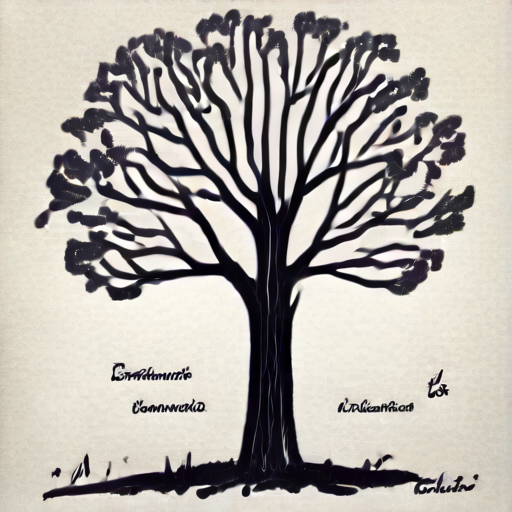

suggested_seed: 885


  0%|          | 0/1 [00:00<?, ?it/s]

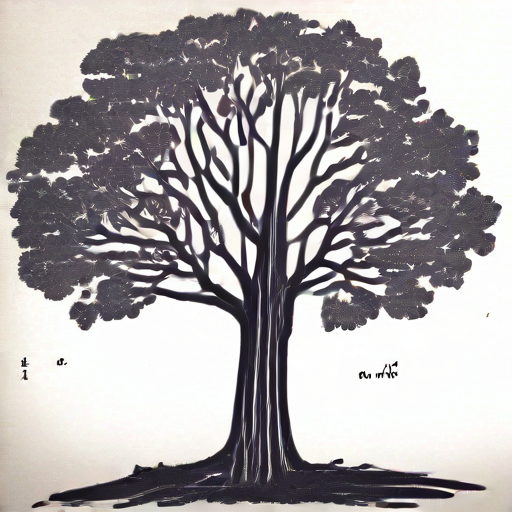

suggested_seed: 333


  0%|          | 0/1 [00:00<?, ?it/s]

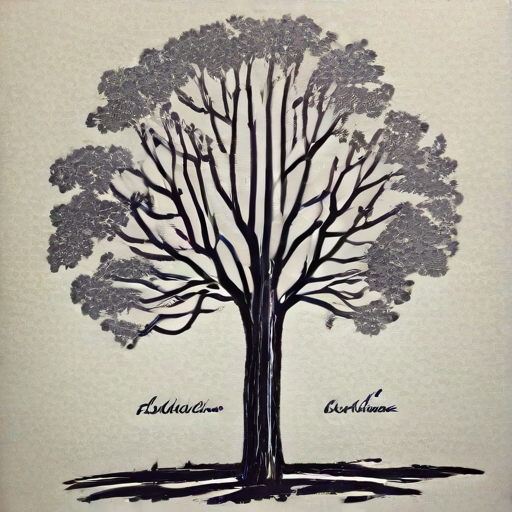

suggested_seed: 275


  0%|          | 0/1 [00:00<?, ?it/s]

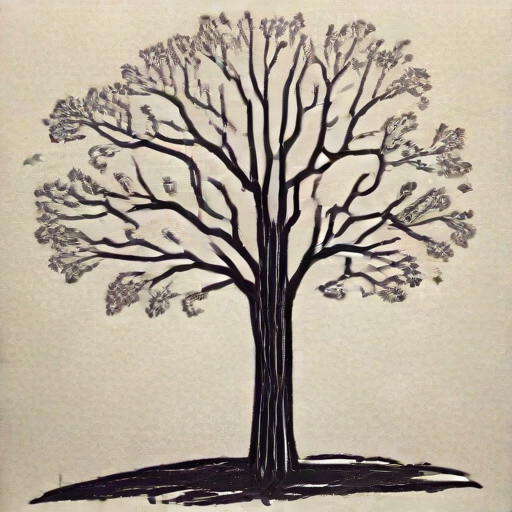

suggested_seed: 592


  0%|          | 0/1 [00:00<?, ?it/s]

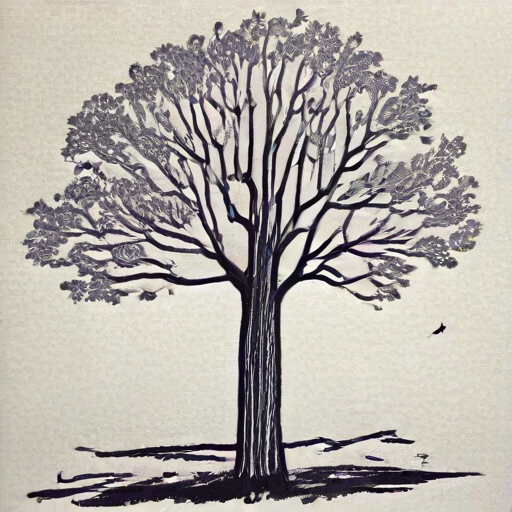

suggested_seed: 601


  0%|          | 0/1 [00:00<?, ?it/s]

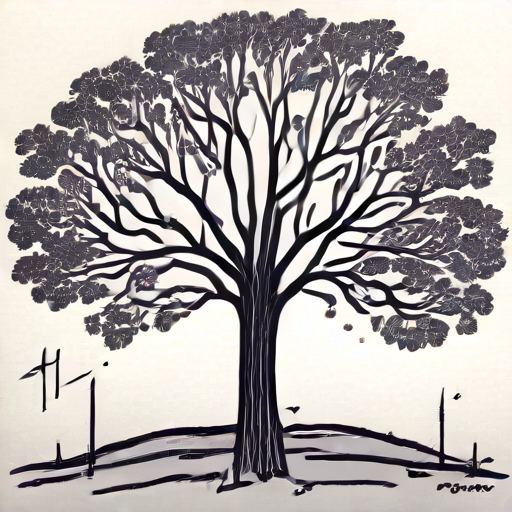

suggested_seed: 881


  0%|          | 0/1 [00:00<?, ?it/s]

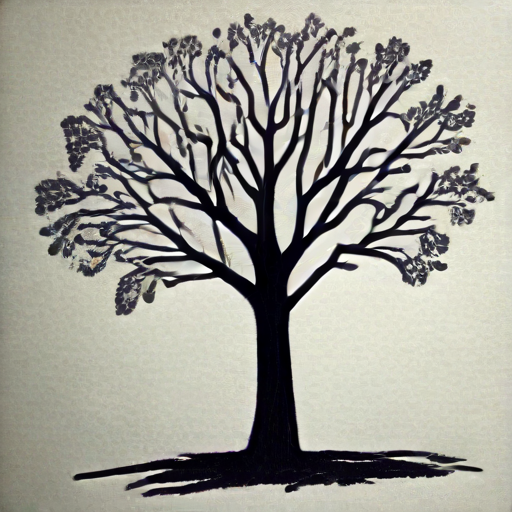

suggested_seed: 113


  0%|          | 0/1 [00:00<?, ?it/s]

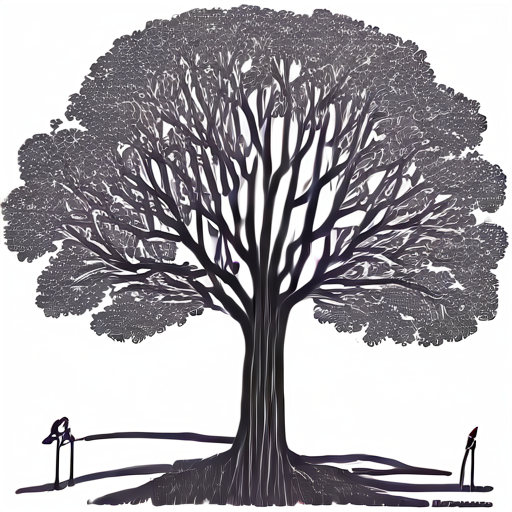

suggested_seed: 271


  0%|          | 0/1 [00:00<?, ?it/s]

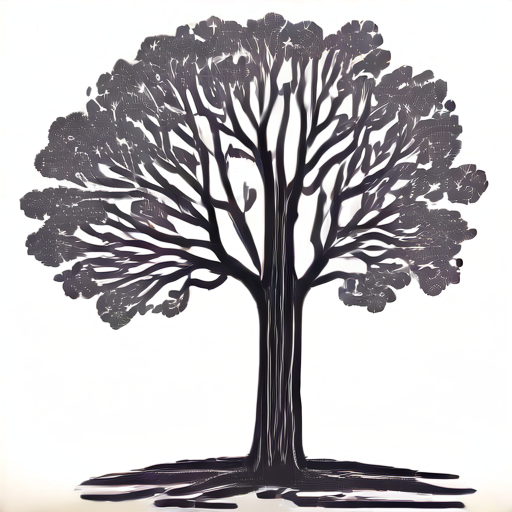

In [10]:
#inspect an individual prompt for tweaking
inspect_num = 1

prompt = processed_prompts[inspect_num]
print(prompt)

# Generate text embeddings for each prompt
embeds_a, pooled_a = compel(prompt)

#generate noisy latents for each prompt
latents_dtype = embeds_a.dtype
torch.manual_seed(seeds[inspect_num])
latent = torch.randn((1, pipeline.unet.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=torch_device, dtype=latents_dtype)

# Generate images for each prompt
image = pipeline(prompt_embeds=embeds_a,
                 pooled_prompt_embeds=pooled_a,
                 latents = latent,
                 num_inference_steps=1,
                 guidance_scale=0.8,
                 height=IMAGE_SIZE,
                 width=IMAGE_SIZE,
                 batch_size=1).images[0]
display(image)


#suggest some alternative seeds:
num_suggestions = 8

for i in range(num_suggestions):

    suggested_seed = np.random.randint(0, 1000)
    print("suggested_seed:", suggested_seed)
    torch.manual_seed(suggested_seed)
    latent = torch.randn((1, pipeline.unet.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=torch_device, dtype=latents_dtype)

    image = pipeline(prompt_embeds=embeds_a,
                     pooled_prompt_embeds=pooled_a,
                     latents = latent,
                     num_inference_steps=1,
                     guidance_scale=0.8,
                     height=IMAGE_SIZE,
                     width=IMAGE_SIZE,
                     batch_size=1).images[0]
    display(image)

cow , black and white, sketch by DaveyDoodle+++++++++++.


  0%|          | 0/1 [00:00<?, ?it/s]

tree , black and white, sketch by DaveyDoodle+++++++++++.


  0%|          | 0/1 [00:00<?, ?it/s]

apple , black and white, sketch by DaveyDoodle+++++++++++.


  0%|          | 0/1 [00:00<?, ?it/s]

bird , black and white, sketch by DaveyDoodle+++++++++++.


  0%|          | 0/1 [00:00<?, ?it/s]

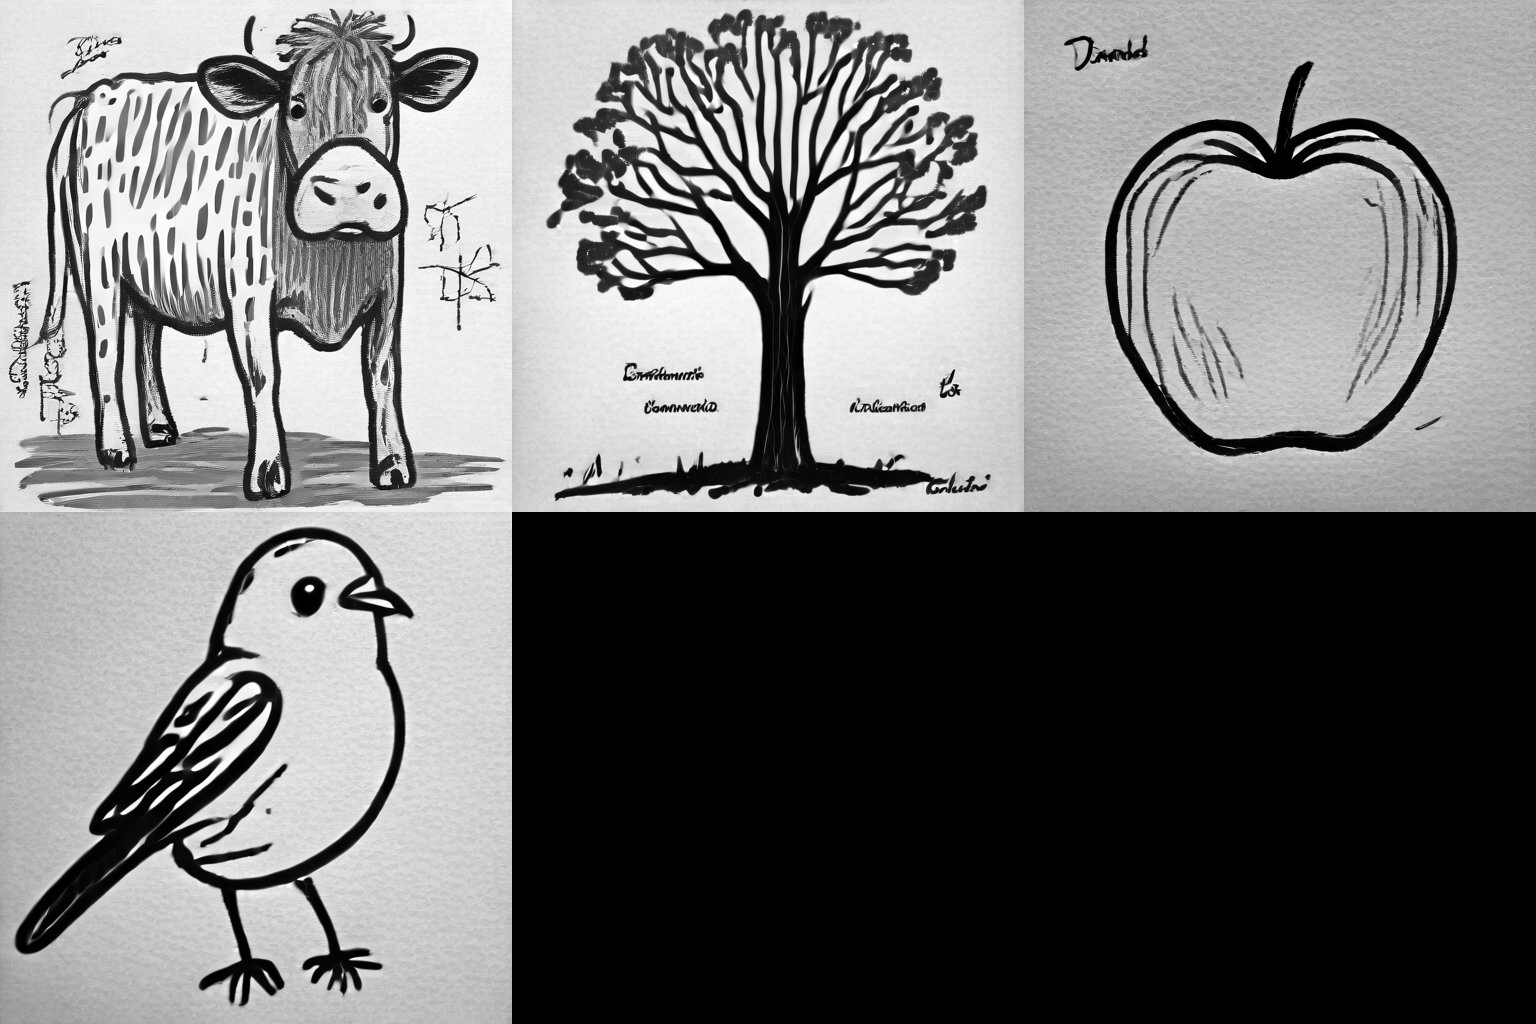

In [11]:
#inspect all key frames before interpolation. 
#tweak seeds and prompts above until you have a selection you like.

generated_images = []

# Iterate through prompts
for i in range(len(processed_prompts)):
    prompt = processed_prompts[i]
    print(prompt)
    
    # Generate embeddings for each prompt
    embeds_a, pooled_a = compel(prompt)

    #generate noisy latents for each prompt
    latents_dtype = embeds_a.dtype
    torch.manual_seed(seeds[i])
    latent = torch.randn((1, pipeline.unet.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=torch_device, dtype=latents_dtype)
    
    # Generate images for each prompt
    image = pipeline(prompt_embeds=embeds_a,
                     pooled_prompt_embeds=pooled_a,
                     latents = latent,
                     num_inference_steps=1,
                     guidance_scale=0.8,
                     height=IMAGE_SIZE,
                     width=IMAGE_SIZE,
                     batch_size=1).images[0]

    generated_images.append(image)

#adapted from code by chatGPT
# Display the generated images in a dynamic grid
num_columns = 3
num_rows = (len(generated_images) + num_columns - 1) // num_columns  # Calculate the number of rows dynamically

grid_image = Image.new('L', (IMAGE_SIZE * num_columns, IMAGE_SIZE * num_rows)) # note that we specify 'L' here for black and white. use 'RGB' if you want full colour

for i, image in enumerate(generated_images):
    row = i // num_columns
    col = i % num_columns
    grid_image.paste(image, (col * IMAGE_SIZE, row * IMAGE_SIZE))

display(grid_image)

  0%|          | 0/1 [00:00<?, ?it/s]

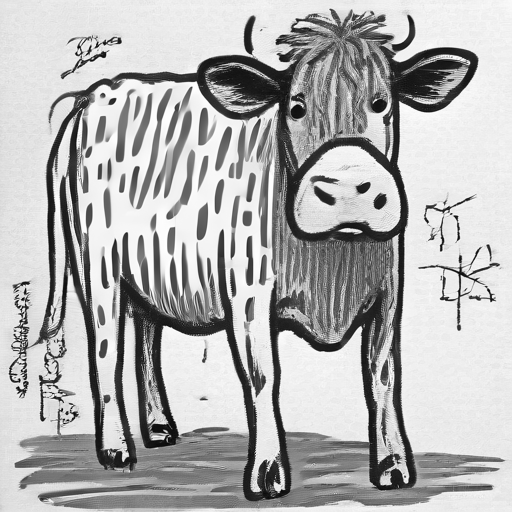

nearest prompt:cow , black and white, sketch by DaveyDoodle+++++++++++.
frame number 0 of 96
frame timestamp: 0.00s / 4.0s
jiggle amount: 0.00
saved as homebrew_interpolation_tests/image00000000.png


  0%|          | 0/1 [00:00<?, ?it/s]

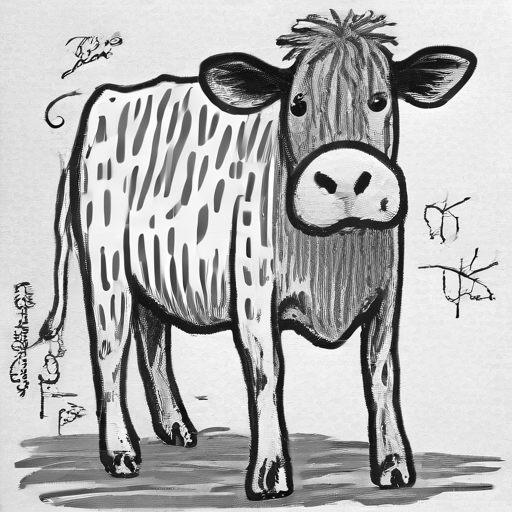

nearest prompt:cow , black and white, sketch by DaveyDoodle+++++++++++.
frame number 1 of 96
frame timestamp: 0.04s / 4.0s
jiggle amount: 0.04
saved as homebrew_interpolation_tests/image00000001.png


  0%|          | 0/1 [00:00<?, ?it/s]

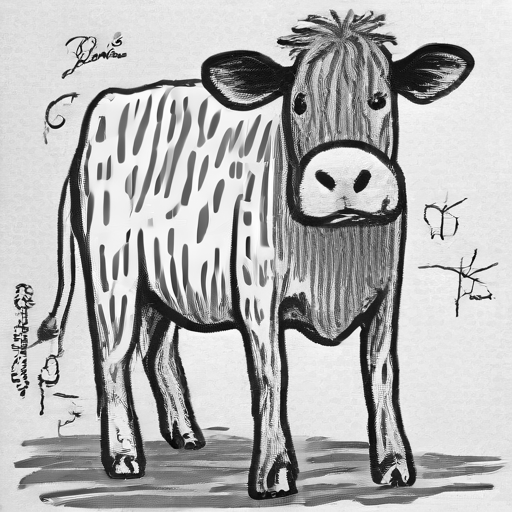

nearest prompt:cow , black and white, sketch by DaveyDoodle+++++++++++.
frame number 2 of 96
frame timestamp: 0.08s / 4.0s
jiggle amount: 0.08
saved as homebrew_interpolation_tests/image00000002.png


  0%|          | 0/1 [00:00<?, ?it/s]

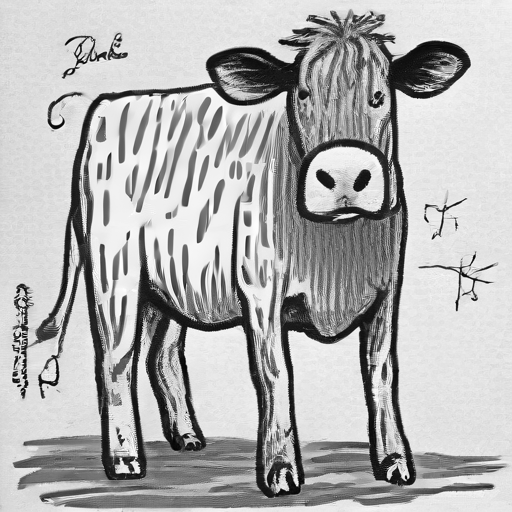

nearest prompt:cow , black and white, sketch by DaveyDoodle+++++++++++.
frame number 3 of 96
frame timestamp: 0.12s / 4.0s
jiggle amount: 0.12
saved as homebrew_interpolation_tests/image00000003.png


  0%|          | 0/1 [00:00<?, ?it/s]

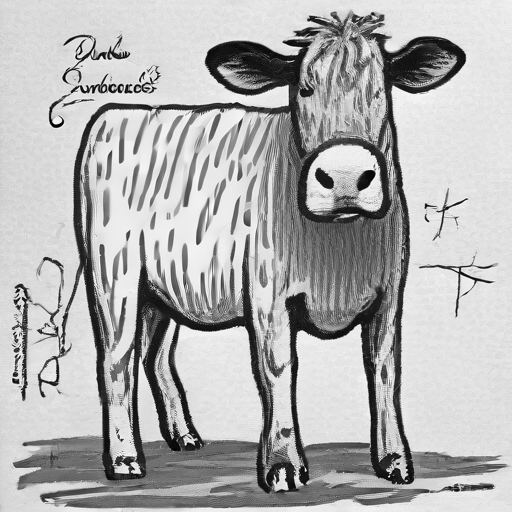

nearest prompt:cow , black and white, sketch by DaveyDoodle+++++++++++.
frame number 4 of 96
frame timestamp: 0.17s / 4.0s
jiggle amount: 0.17
saved as homebrew_interpolation_tests/image00000004.png


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# The big bit: generating the frames.

# Mostly adapted from https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355
# And https://github.com/nateraw/stable-diffusion-videos/tree/main

# Sometimes when walking through latent space you'll get intermediate images that strongly deviate from the style and prompts.
# i.e in my case some intermediate steps went photrealistic instead of doodles
# Changing to 2 fps lets you check these intermediate bits and tweak seeds and prompt before doing a proper run.
fps = 24

for i in range(len(processed_prompts)):

    #figures out neighbouring prompts and seeds that we will interpolate between
    prompt_1 = processed_prompts[i]
    prompt_2 = processed_prompts[(i + 1) % len(processed_prompts)]
    seed_1 = seeds[i]
    seed_2 = seeds[(i + 1) % len(seeds)]
    

    # Specify the number of interpolation steps
    num_steps = fps # This just changes prompt every second. Could do bpm matching by fiddling with this. (e.g change every bar) 

    # This could be sped up and parellelized by passing batches of latents and embeddings to the pipeline, 
    # but doing it in a loop is fast enough for my purposes.
    for step in range(num_steps + 1):

        #here's where we get the embeddings for our prompts
        embeds_a, pooled_a = compel(prompt_1)
        embeds_b, pooled_b = compel(prompt_2)

        #here's where we generate our noisy latents for diffusion
        torch.manual_seed(seed_1)
        init_1 = torch.randn((1, pipeline.unet.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=torch_device, dtype=latents_dtype)
        torch.manual_seed(seed_2)
        init_2 = torch.randn((1, pipeline.unet.in_channels, IMAGE_SIZE // 8, IMAGE_SIZE // 8), device=torch_device, dtype=latents_dtype)

        #Here's where the audio reaction and latent interpolation happens!
        image_num = ((i * num_steps) + step)
        frame_timestamp = image_num/num_steps
        time_differences = [abs(onset_time - frame_timestamp) for onset_time in beatmap_contents] # Check if the frame timestamp is near any of the times in beatmap_contents
        min_value = min(time_differences) # Calculate min and max values
        max_value = max(time_differences)
        normalized_time_dif = (time_differences[0] - min_value) / (max_value - min_value) # Normalize the list of values between 0 and 1
        weight = step / num_steps # variable controls latent interpolation between two keyframes
        jiggle = weight + normalized_time_dif #simple implementation, could be more elaborate for more pronounced effect
        interpolated_prompt = torch.lerp(embeds_a, embeds_b, weight) #replace weight with jiggle here to have prompt interpolation react to audio
        interpolated_noise = slerp(float(jiggle), init_1, init_2)

        #generate the frame
        image = pipeline(prompt_embeds=interpolated_prompt, 
                         pooled_prompt_embeds=pooled_a,
                         latents = interpolated_noise,
                         num_inference_steps=1,
                         guidance_scale=0.0,
                         height=IMAGE_SIZE,
                         width=IMAGE_SIZE,
                         batch_size=1).images[0]

        #display and save the frame
        image = ImageOps.grayscale(image) #Note, the image is converted to black and white here, remove this line if you want full colour.
        display(image)
        image_name = f"{image_sequence_path}/image{str(image_num).zfill(8)}.png"
        image.save(image_name)
        torch.cuda.empty_cache() #housekeeping, unsure if necessary though.

        # Print some info about the frame.
        print(f"nearest prompt:{processed_prompts[round(i + weight)]}")
        images_to_generate = len(processed_prompts) * num_steps
        video_length = images_to_generate/fps
        print(f"frame number {image_num} of {images_to_generate}")
        print(f"frame timestamp: {frame_timestamp:.2f}s / {video_length}s")
        print(f"jiggle amount: {jiggle:.2f}")
        print(f"saved as {image_name}")

In [ ]:
#create and save a video

create_video(image_sequence_path, 
             audio_file_path, 
             output_video_path, 
             fps)

Video(output_video_path)